In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/NCKH/HurricanePath

/content/drive/MyDrive/NCKH/HurricanePath


In [ ]:
!ls

 1920-2012-data.csv		    'hurricane-transformer mlp.ipynb'
 2017-2021.gsheet		     model_sheils.h5
'2023-03-10 23-03-54.mkv'	     model_sheils.json
 checkpoint-dataframe-2.0.csv	     model_transformer.h5
 checkpoint-dataframe.csv	     model_transformer.json
 hurricane-rnn-sheils.ipynb	     model_transformer_latlong.h5
 hurricane-transformer-6plus.ipynb   model_transformer_latlong.json
 hurricane-transformer.ipynb


# SparkDev AI Hurricane Trajectory Prediction

In this project, we'll be using neural networks to predict the trajectory paths of hurricanes in South Florida. We will be using the Hurricane Database dataset from Unisys Weather. Here we will preprocess the data, then train a recurrent neural network on some of the samples. At the end, we'll get to see our neural network's hurricane trajectory path predictions.

### Get and Analyze the Data

[Here's the link containing the entire dataset.](http://weather.unisys.com/hurricane/atlantic/) So far, we're using only the years 2000 to 2009 and is saved on our repo as '2000-2009-data.csv'. We have to get an idea of the hurricanes' behavior to properly create a model for our neural network.

In [ ]:
!pip install basemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.2/859.2 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 101.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 84.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


In [ ]:
# ALL THE IMPORTS NECESSARY
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from geopy.distance import great_circle as vc
import math as Math

from mpl_toolkits.basemap import Basemap
import matplotlib.cm as cm

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
import keras
from keras import layers
from keras import activations
import math, time

from keras.models import model_from_json

In [ ]:
data = pd.read_csv('1920-2012-data.csv', index_col=None, names=['Year', 'Month', 'Day', 'Hour', 'HurricaneNum', 'Name', 'Lat', 'Long', 'WindSpeed', 'Pressure', 'NullCol'])

# Create a unique key for all of the hurricane
data['unique-key'] = data['Name'] + '-' + data['Year'].map(str) + '-' + data['HurricaneNum'].map(str)

# Delete the columns of information that we are not using so far
data.drop(['Name', 'HurricaneNum', 'Year', 'NullCol'], axis = 1, inplace = True)

# Preview the first 5 rows of data
data.head()

,Month,Day,Hour,Lat,Long,WindSpeed,Pressure,unique-key
0,6,7,18,21,-93.0,25.0,0,NOTNAMED-2000-1
1,6,8,0,20.9,-92.8,25.0,0,NOTNAMED-2000-1
2,6,8,6,20.7,-93.1,25.0,0,NOTNAMED-2000-1
3,6,8,12,20.8,-93.5,25.0,0,NOTNAMED-2000-1
4,6,23,0,9.5,-19.8,25.0,0,NOTNAMED-2000-2


In [ ]:
# Remove hurricanes where pressure = 0
data = data[data['Pressure'] != 0]
data.head()

,Month,Day,Hour,Lat,Long,WindSpeed,Pressure,unique-key
16,8,3,18,10.8,-18.0,25.0,1007,ALBERTO-2000-3
17,8,4,0,11.5,-20.1,30.0,1005,ALBERTO-2000-3
18,8,4,6,12,-22.3,35.0,1004,ALBERTO-2000-3
19,8,4,12,12.3,-23.8,35.0,1003,ALBERTO-2000-3
20,8,4,18,12.7,-25.2,40.0,1002,ALBERTO-2000-3


In [ ]:
# Total amount of hurricanes we have in our dataset
total_hurricane_count = len(pd.unique(data['unique-key']))
print(total_hurricane_count)

790


In [ ]:
# Finding errors in CSV
print(data[data['Lat'].str.contains("NAMED")])

data = data[~data['Lat'].str.contains("NAMED")]

      Month  Day  Hour    Lat  Long  WindSpeed  Pressure   unique-key
5997      8   31    12  NAMED  37.1      -64.3        25  NOT-2011-20
5998      8   31    18  NAMED  37.1      -64.1        25  NOT-2011-20
5999      9    1     0  NAMED  37.3      -63.9        25  NOT-2011-20
6000      9    1     6  NAMED  37.4      -63.7        30  NOT-2011-20
6001      9    1    12  NAMED  37.4      -63.7        40  NOT-2011-20
6002      9    1    18  NAMED  37.4      -63.8        35  NOT-2011-20
6003      9    2     0  NAMED  37.5      -63.8        35  NOT-2011-20
6004      9    2     6  NAMED  37.8      -63.7        40  NOT-2011-20
6005      9    2    12  NAMED  38.0      -62.8        40  NOT-2011-20
6006      9    2    18  NAMED  39.0      -61.8        35  NOT-2011-20
6007      9    3     0  NAMED  40.0      -60.7        30  NOT-2011-20
6008      9    3     6  NAMED  41.0      -59.9        30  NOT-2011-20
6009      9    3    12  NAMED  42.0      -59.2        30  NOT-2011-20
6010      9    3    

In [ ]:
# Total amount of hurricanes we have in our dataset
total_hurricane_count = len(pd.unique(data['unique-key']))
print(total_hurricane_count)

789


In [ ]:
# Since our keys are strings, we enumerate them to access them as integers
keys = list(enumerate(pd.unique(data['unique-key'])))

total_hurricane_count = len(pd.unique(data['unique-key']))
print(total_hurricane_count)

y = np.zeros((total_hurricane_count))
for x in range(0,total_hurricane_count):
    y[x] = len(pd.DataFrame(data[data['unique-key'] == keys[x][1]], columns = data.keys()).reset_index(drop = True))

# Now contains how many time instances of data (or rows) each hurricane contains
hurricane_amount = pd.DataFrame(y)

789


In [ ]:
# Print the hurricane key with the amount of data they contain
print ('Top 6 Hurricanes (in terms of data quantity)')
for x in hurricane_amount.nlargest(6, 0).index:
    print (keys[x][1], "-", hurricane_amount.loc[x][0])

# Provides statistical information about the DataFrame
# From here we can see that the shortest hurricane only has 4 rows of information and the largest hurricane has 94 rows
hurricane_amount.describe()

Top 6 Hurricanes (in terms of data quantity)
NADINE-2012-14 - 96.0
IVAN-2004-9 - 94.0
KYLE-2002-12 - 90.0
ALBERTO-2000-3 - 87.0
ARLENE-1987-2 - 81.0
NICHOLAS-2003-19 - 80.0


,0
count,789.000000
mean,20.778200
std,18.740283
min,1.000000
25%,6.000000
50%,15.000000
75%,31.000000
max,96.000000


In [ ]:
cond = (hurricane_amount > 6) & (hurricane_amount < 60)
keys25 = []

for x in cond.index:
    if cond.loc[x][0]:
        keys25.append(keys[x][1])

word2keys = {}
for x in keys:
    word2keys[x[1]] = x[0]

data = data[data['unique-key'].isin(keys25)]
keys = list(enumerate(pd.unique(data['unique-key'])))
data.head()

,Month,Day,Hour,Lat,Long,WindSpeed,Pressure,unique-key
116,8,13,18,22.5,-93.5,30.0,1008,BERYL-2000-5
117,8,14,0,22.7,-93.8,30.0,1008,BERYL-2000-5
118,8,14,6,23.1,-94.6,35.0,1007,BERYL-2000-5
119,8,14,12,23.5,-95.4,40.0,1009,BERYL-2000-5
120,8,14,18,23.9,-96.3,45.0,1009,BERYL-2000-5


In [ ]:
# Print the hurricane key with the amount of data they contain
print ('Top 6 Hurricanes (in terms of data quantity)')
for x in hurricane_amount.nlargest(6, 0).index:
    print (keys[x][1], "-", hurricane_amount.loc[x][0])

Top 6 Hurricanes (in terms of data quantity)
FABIAN-1991-9 - 96.0
EMILY-2005-5 - 94.0
DANNY-2003-5 - 90.0
BERYL-2000-5 - 87.0
IRENE-1971-18 - 81.0
HERMINE-2004-8 - 80.0


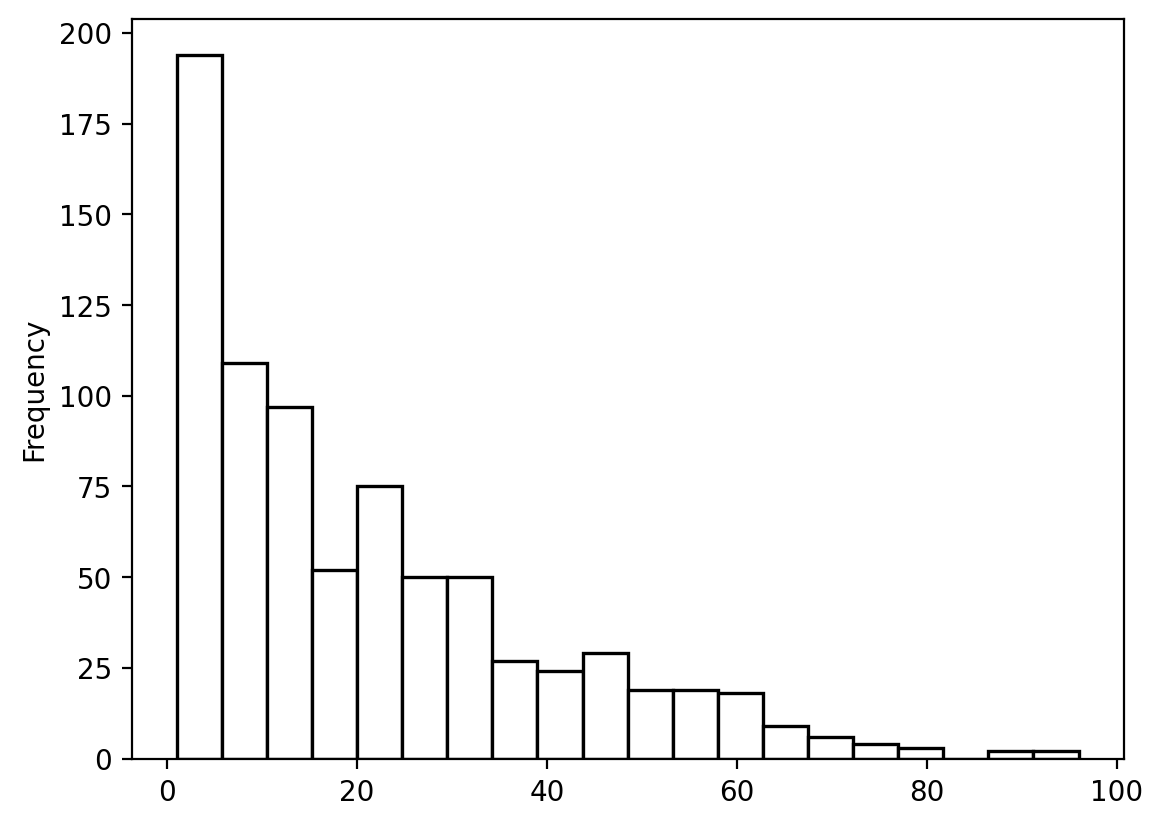

In [ ]:
# Print the distribution of data quantity for all hurricanes
dist = hurricane_amount.plot.hist(bins=20, edgecolor='black', histtype='barstacked', color='white', legend=None, linewidth=1.2)
plt.show()

In [ ]:
data.describe()

,Month,Day,Hour,Long,WindSpeed,Pressure
count,13131.000000,13131.000000,13131.000000,13131.000000,13131.000000,13131.000000
mean,8.724621,15.828269,9.186810,-64.398149,50.883939,993.863834
std,1.375840,8.906905,6.729553,20.182565,25.903755,18.023786
min,1.000000,1.000000,0.000000,-109.300000,10.000000,882.000000
25%,8.000000,8.000000,6.000000,-80.700000,30.000000,987.000000
50%,9.000000,16.000000,12.000000,-65.800000,45.000000,1000.000000
75%,10.000000,24.000000,18.000000,-49.500000,65.000000,1007.000000
max,12.000000,31.000000,23.000000,13.500000,165.000000,1024.000000


In [ ]:
# Since our keys are strings, we enumerate them to access them as integers
keys = list(enumerate(pd.unique(data['unique-key'])))

total_hurricane_count = len(pd.unique(data['unique-key']))
print(total_hurricane_count)

y = np.zeros((total_hurricane_count))
for x in range(0,total_hurricane_count):
    y[x] = len(pd.DataFrame(data[data['unique-key'] == keys[x][1]], columns = data.keys()).reset_index(drop = True))

# Now contains how many time instances of data (or rows) each hurricane contains
hurricane_amount = pd.DataFrame(y)

539


In [ ]:
# Total amount of data tuples
total_data_count = len(data)
print(total_data_count)

13131


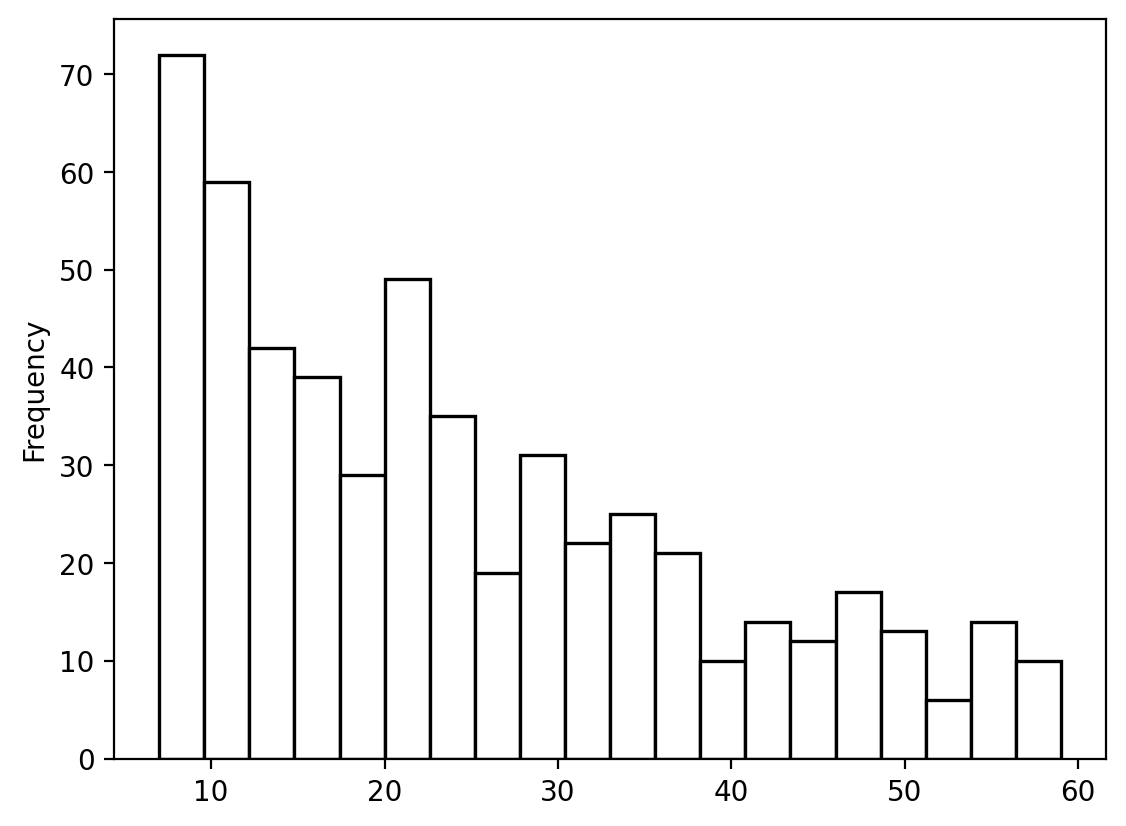

In [ ]:
# Print the distribution of data quantity for all hurricanes
dist = hurricane_amount.plot.hist(bins=20, edgecolor='black', histtype='barstacked', color='white', legend=None, linewidth=1.2)
# plt.savefig('frequency_graph', dpi=600)
plt.show()

In [ ]:
data.to_csv('checkpoint-dataframe.csv') # Save the dataframe to csv for checkpoint

### Data Preprocessing

From the dataset, we have latitude and longitude. It is easier for the neural network to learn from distance vectors since these values do not contain negative values (like latitude and longitude). To preprocess our data, we will calculate the angle of travel and distance between each given point and add that as new columns to our DataFrame. In addition, we will remove the outlier hurricanes, to get a more normal distribution to insert into the neural network.

In [ ]:
data = pd.read_csv('checkpoint-dataframe.csv', index_col=0, header=0)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13131 entries, 116 to 33176
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       13131 non-null  int64  
 1   Day         13131 non-null  int64  
 2   Hour        13131 non-null  int64  
 3   Lat         13131 non-null  float64
 4   Long        13131 non-null  float64
 5   WindSpeed   13131 non-null  float64
 6   Pressure    13131 non-null  int64  
 7   unique-key  13131 non-null  object 
dtypes: float64(3), int64(4), object(1)
memory usage: 923.3+ KB


**⚠ Quan trọng**

In [ ]:
keys = list(enumerate(pd.unique(data['unique-key'])))
keys[:5]

[(0, 'BERYL-2000-5'),
 (1, 'CHRIS-2000-6'),
 (2, 'DEBBY-2000-7'),
 (3, 'ERNESTO-2000-8'),
 (4, 'FLORENCE-2000-10')]

In [ ]:
total_hurricane_count = len(pd.unique(data['unique-key']))
total_hurricane_count

539

In [ ]:
y = np.zeros(total_hurricane_count)
data['distance'] = np.zeros(total_data_count)
data['direction'] = np.zeros(total_data_count)

# Chạy vòng lặp cho tất cả các cơn bão
for x in range(0, total_hurricane_count):
    # lấy các thuộc tính của cơn bão
    t = pd.DataFrame(data[data['unique-key'] == keys[x][1]], columns = data.keys()).reset_index(drop = False)
    dst = 0           # khoảng cách
    prev = (0,0)      # đánh dấu vị trí trước của cơn bão

    # Với tất cả điểm kinh độ và vĩ độ của cơn bão, tính hướng di chuyển và khoảng cách
    for p in zip(t['Lat'], t['Long']):
        # lấy vị trí đầu tiên cơn bão xuất hiện
        if prev == (0,0):
            prev = p
            continue
        # tính khoảng cách giữa điểm hiện tại và điểm trước đó vào cho vào dữ liệu qua cột "distance"
        data.at[t[(t['Lat'] == p[0]) & (t['Long'] == p[1])]['index'].values[0], 'distance'] =  vc(prev,p).miles

        # tính góc di chuyển
        dLon = p[1] - prev[1];
        temp = float(p[0])
        y_x = Math.sin(dLon) * Math.cos(temp);

        x_x = Math.cos(p[1]) * Math.sin(temp) - Math.sin(p[1]) * Math.cos(temp) * Math.cos(dLon);
        brng = Math.degrees(Math.atan2(y_x, x_x)) # Math.degrees để chuyển radian sang độ
        # đề phòng góc bị âm
        if (brng < 0):
            brng += 360;

        # Lưu góc vào dữ liệu
        data.at[t[(t['Lat'] == p[0]) & (t['Long'] == p[1])]['index'].values[0], 'direction'] = brng
        # tính tổng khoảng cách đi được
        dst += vc(prev,p).miles
        # cập nhật lại điểm trước đó
        prev = p
    # lưu tổng khoảng cách
    y[x] = dst

# biến thành dataFrame để dễ sử dụng sau đó
hurricane_distance = pd.DataFrame(y)

In [ ]:
# Columns have been added
data.head()

,Month,Day,Hour,Lat,Long,WindSpeed,Pressure,unique-key,distance,direction
116,8,13,18,22.5,-93.5,30.0,1008,BERYL-2000-5,0.000000,0.000000
117,8,14,0,22.7,-93.8,30.0,1008,BERYL-2000-5,23.604117,140.567975
118,8,14,6,23.1,-94.6,35.0,1007,BERYL-2000-5,57.935076,161.351184
119,8,14,12,23.5,-95.4,40.0,1009,BERYL-2000-5,57.802056,174.302218
120,8,14,18,23.9,-96.3,45.0,1009,BERYL-2000-5,63.292296,337.250833


In [ ]:
print(hurricane_distance.shape)

(539, 1)


In [ ]:
# Here we can see that the hurricane that traveled the least only traveled 65 miles, while the one that traveled the most traveled 8402 miles
hurricane_distance.describe()

,0
count,539.000000
mean,2171.303649
std,1361.057169
min,86.434363
25%,1086.740042
50%,1871.643323
75%,2951.363435
max,6392.865052


In [ ]:
# Print the hurricane key with the amount of data they contain
print ('Top 6 Hurricanes (in terms of distance traveled)')
for x in hurricane_distance.nlargest(6, 0).index:
    print (keys[x][1], "-", hurricane_distance.loc[x][0], "miles -", hurricane_amount.loc[x][0])

# print(len(hurricane_distance[0]))
# print(len(hurricane_amount[0]))

Top 6 Hurricanes (in terms of distance traveled)
KATE-2003-16 - 6392.865052499503 miles - 58.0
BERTHA-1996-2 - 6391.7852319952735 miles - 51.0
RAFAEL-2012-17 - 6351.748249370006 miles - 56.0
BILL-2009-3 - 6236.426920398357 miles - 46.0
EARL-2010-7 - 6197.2768847902635 miles - 55.0
ISAAC-2000-13 - 6156.937260531036 miles - 52.0


[[1.        0.7385791]
 [0.7385791 1.       ]]


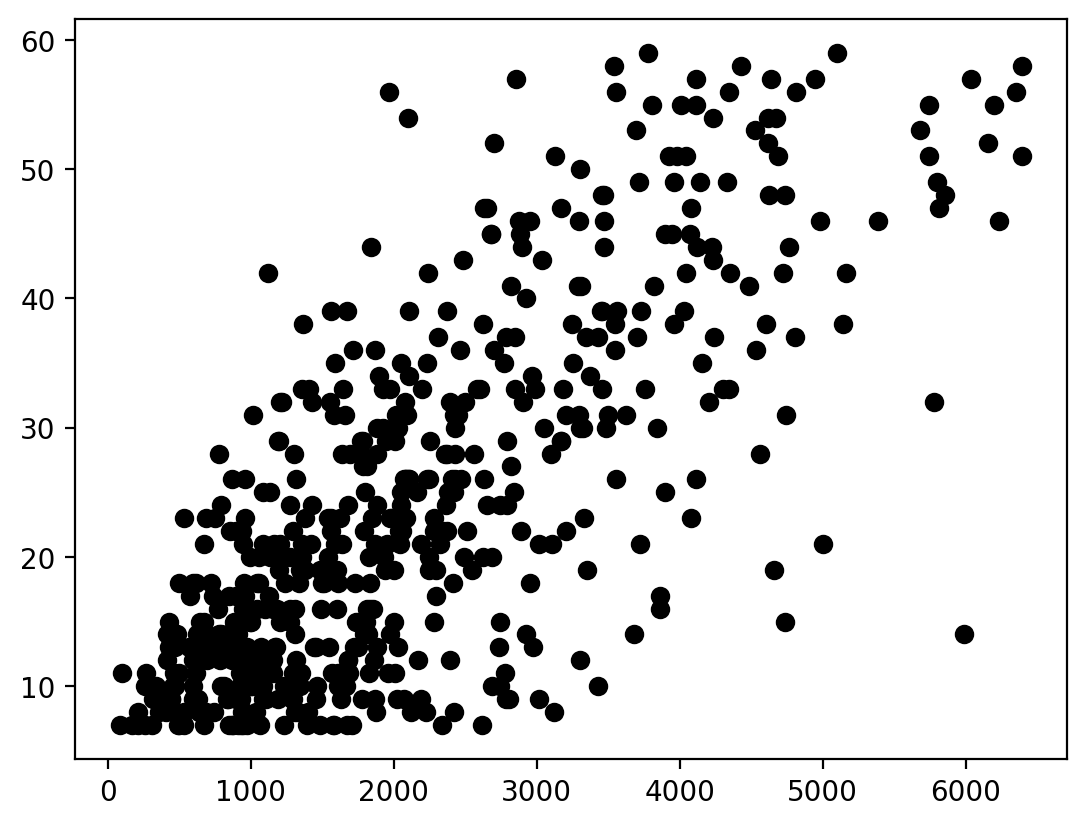

In [ ]:
print( np.corrcoef(hurricane_distance[0], hurricane_amount[0]) )
# Plotted the amount of hurricane distance traveled vs the amount of data they contain.
corr = plt.scatter(hurricane_distance[0], hurricane_amount[0], color='black')
# plt.savefig('points_vs_distance', dpi=600)
plt.show()

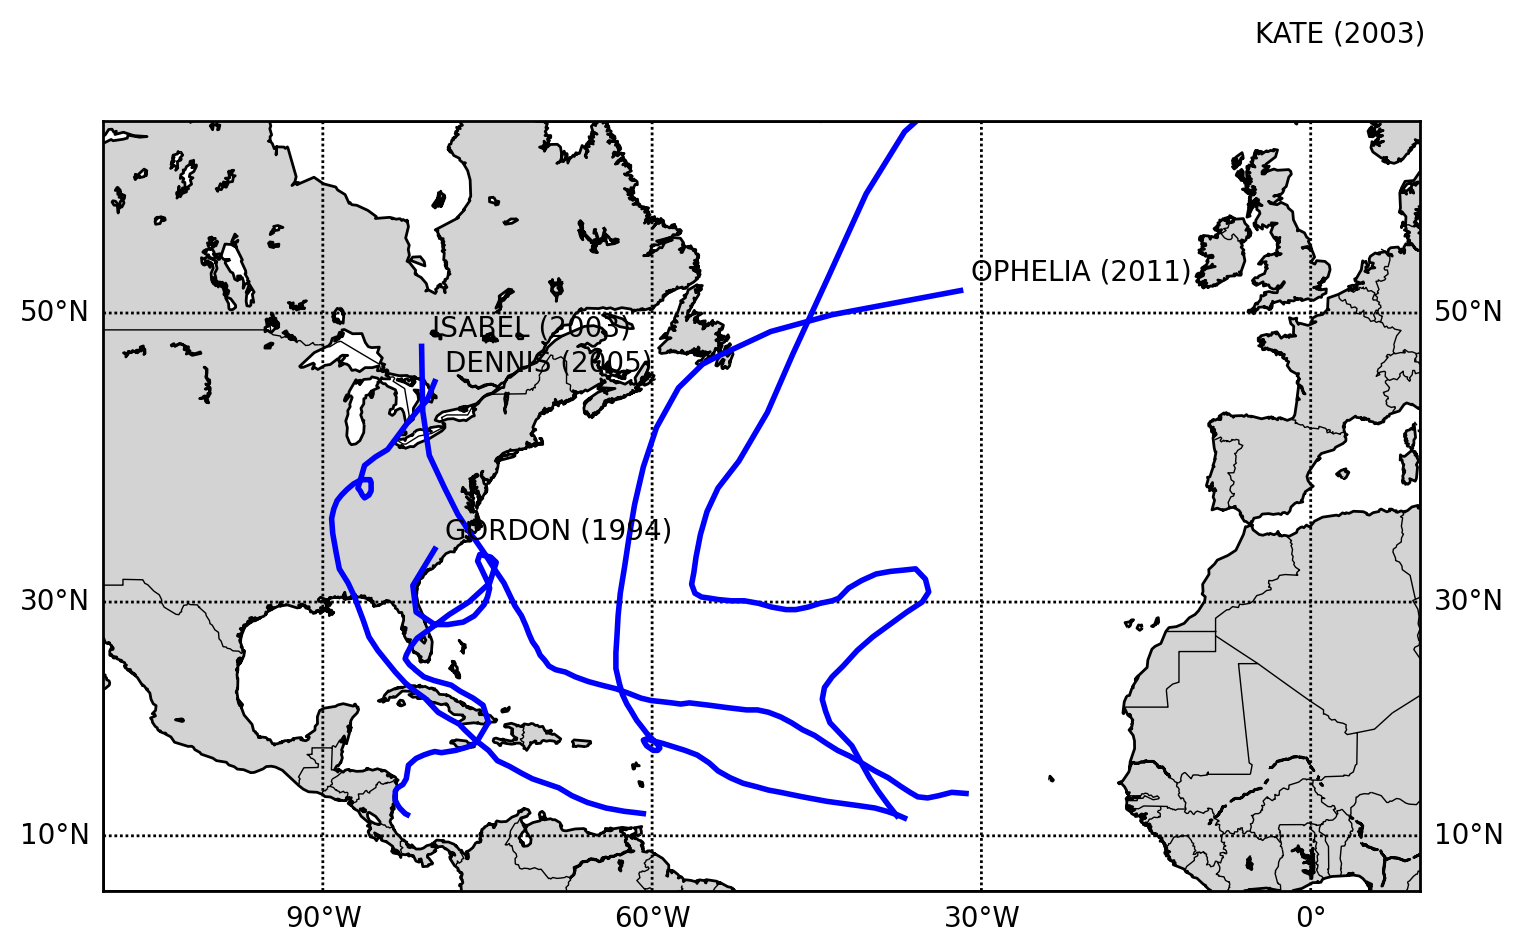

In [ ]:
n = 5 # Number of hurricanes

# Graph the trajectories of the longest hurricanes (the ones that traveled the most)
plt.figure(figsize=(10,5))
m = Basemap(llcrnrlon=-110.,llcrnrlat=5.,urcrnrlon=10.,urcrnrlat=60.,
            rsphere=(6378137.00,6356752.3142),
            resolution='l',
            projection='merc',
            lat_0=40.,lon_0=-20.,lat_ts=20.)
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='#D3D3D3')
m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])

for x in hurricane_amount.nlargest(n,0).index:
    largest_hurr = data[data['unique-key'] == keys[x][1]]
    lat = largest_hurr['Lat'].values
    long = largest_hurr['Long'].values
    xpt, ypt = m(long, lat)
    plt.text(xpt[len(lat) - 1]+100000,ypt[len(long) - 1]+100000, '%s (%s)' % (keys[x][1].split('-')[0],keys[x][1].split('-')[1]))
    m.plot(xpt, ypt, linewidth=2, color='blue')

# plt.title('Top 5 Atlantic Hurricanes (Distance Traveled)')
# plt.savefig('largest_dist_hurricanes')
plt.show()

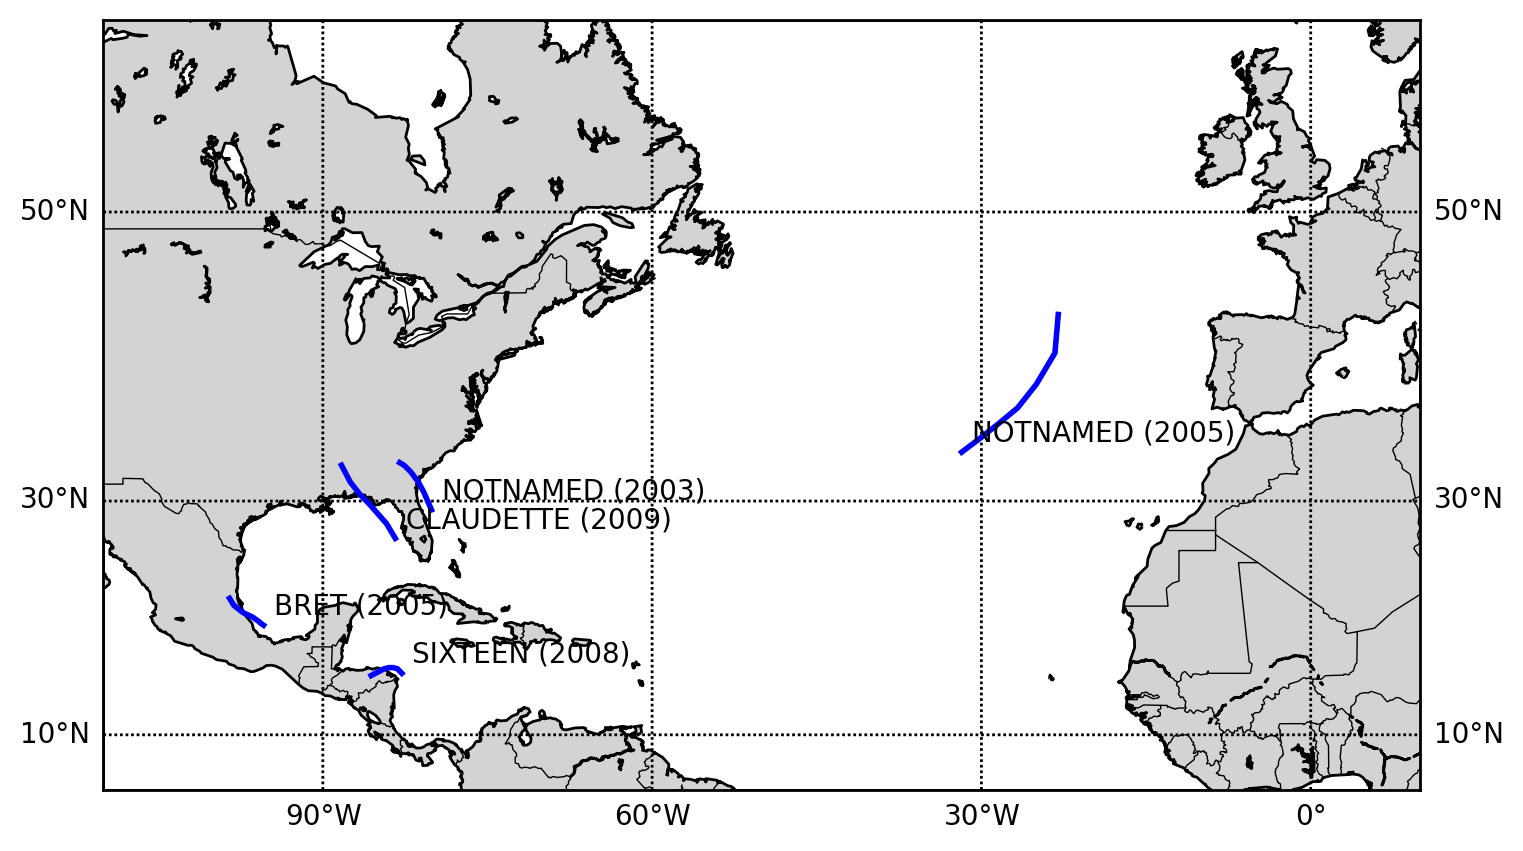

In [ ]:
# Graph the trajectories of the shortest hurricanes (the ones that traveled the least)
plt.figure(figsize=(10,5))
m = Basemap(llcrnrlon=-110.,llcrnrlat=5.,urcrnrlon=10.,urcrnrlat=60.,
            rsphere=(6378137.00,6356752.3142),
            resolution='l',
            projection='merc',
            lat_0=40.,lon_0=-20.,lat_ts=20.)
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='#D3D3D3')
m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])

for x in hurricane_amount.nsmallest(n,0).index:
    largest_hurr = data[data['unique-key'] == keys[x][1]]
    lat = largest_hurr['Lat'].values
    long = largest_hurr['Long'].values
    xpt, ypt = m(long, lat)
    plt.text(xpt[0]+100000,ypt[0]+100000, '%s (%s)' % (keys[x][1].split('-')[0],keys[x][1].split('-')[1]))
    m.plot(xpt, ypt, linewidth=2, color='blue')

# plt.title('Smallest 5 Atlantic Hurricanes (Distance Traveled)')
# plt.savefig('smallest_dist_hurricanes')
plt.show()

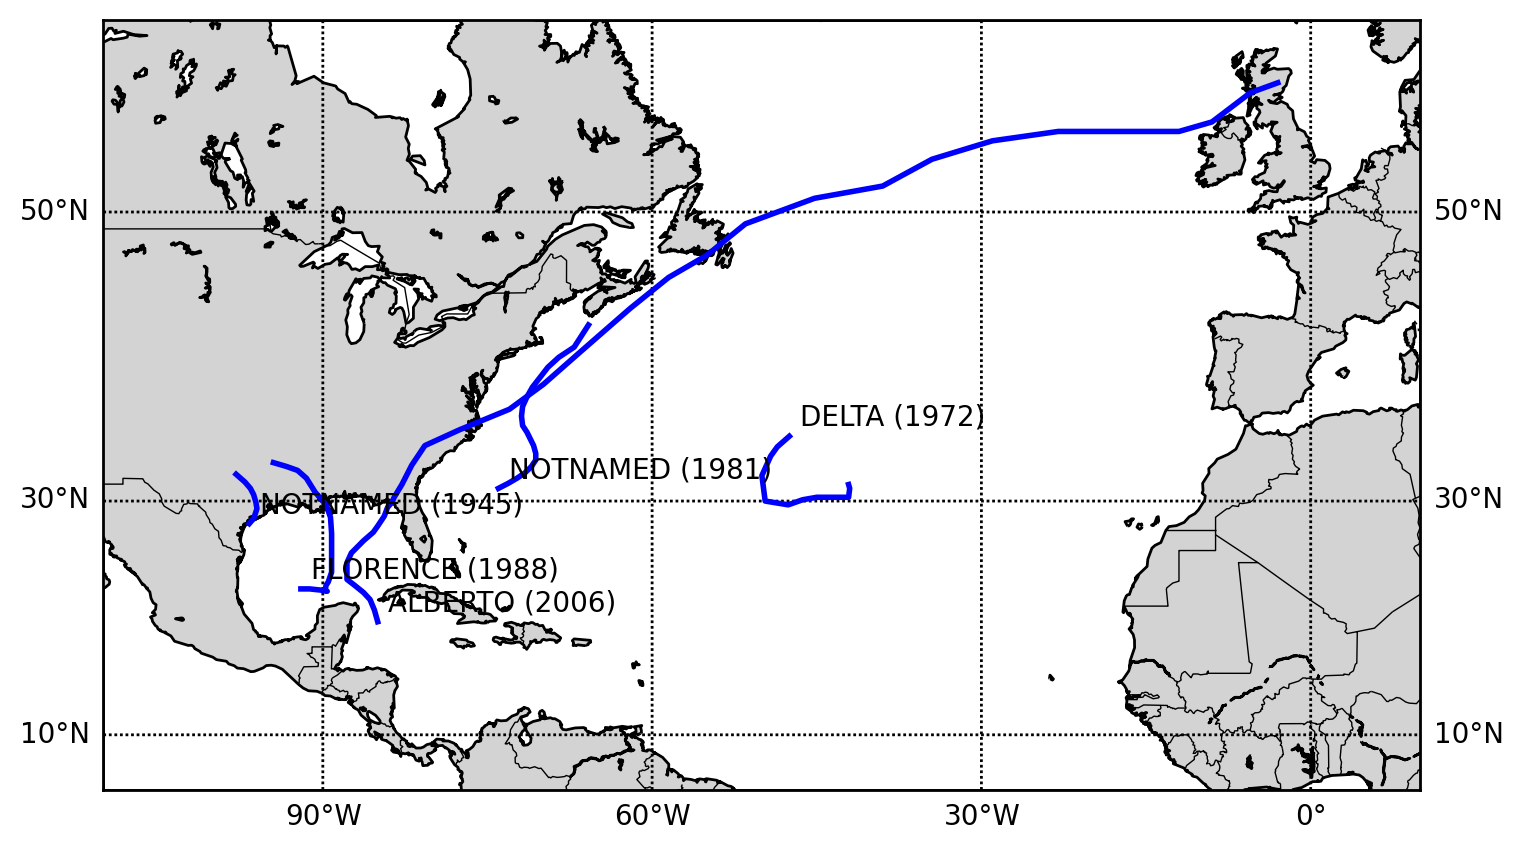

In [ ]:
# Graph the trajectories of 3 random hurricanes
plt.figure(figsize=(10,5))
m = Basemap(llcrnrlon=-110.,llcrnrlat=5.,urcrnrlon=10.,urcrnrlat=60.,
            rsphere=(6378137.00,6356752.3142),
            resolution='l',
            projection='merc',
            lat_0=40.,lon_0=-20.,lat_ts=20.)
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='#D3D3D3')
m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])

for x in np.random.choice(total_hurricane_count, n):
    largest_hurr = data[data['unique-key'] == keys[x][1]]
    lat = largest_hurr['Lat'].values
    long = largest_hurr['Long'].values
    xpt, ypt = m(long, lat)
    plt.text(xpt[0]+100000,ypt[0]+100000, '%s (%s)' % (keys[x][1].split('-')[0],keys[x][1].split('-')[1]))
    m.plot(xpt, ypt, linewidth=2, color='blue')

# plt.title('Random 5 Atlantic Hurricanes')
# plt.savefig('random_dist_hurricanes')
plt.show()

In [ ]:
data.head()

,Month,Day,Hour,Lat,Long,WindSpeed,Pressure,unique-key,distance,direction
116,8,13,18,22.5,-93.5,30.0,1008,BERYL-2000-5,0.000000,0.000000
117,8,14,0,22.7,-93.8,30.0,1008,BERYL-2000-5,23.604117,140.567975
118,8,14,6,23.1,-94.6,35.0,1007,BERYL-2000-5,57.935076,161.351184
119,8,14,12,23.5,-95.4,40.0,1009,BERYL-2000-5,57.802056,174.302218
120,8,14,18,23.9,-96.3,45.0,1009,BERYL-2000-5,63.292296,337.250833


In [ ]:
import scipy

dist = data[data['distance'] > 0]['distance']
scipy.stats.anderson(dist, dist='norm')

AndersonResult(statistic=814.2159961835368, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=93.340940957261, scale=85.1877445710356)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

<Axes: ylabel='Density'>

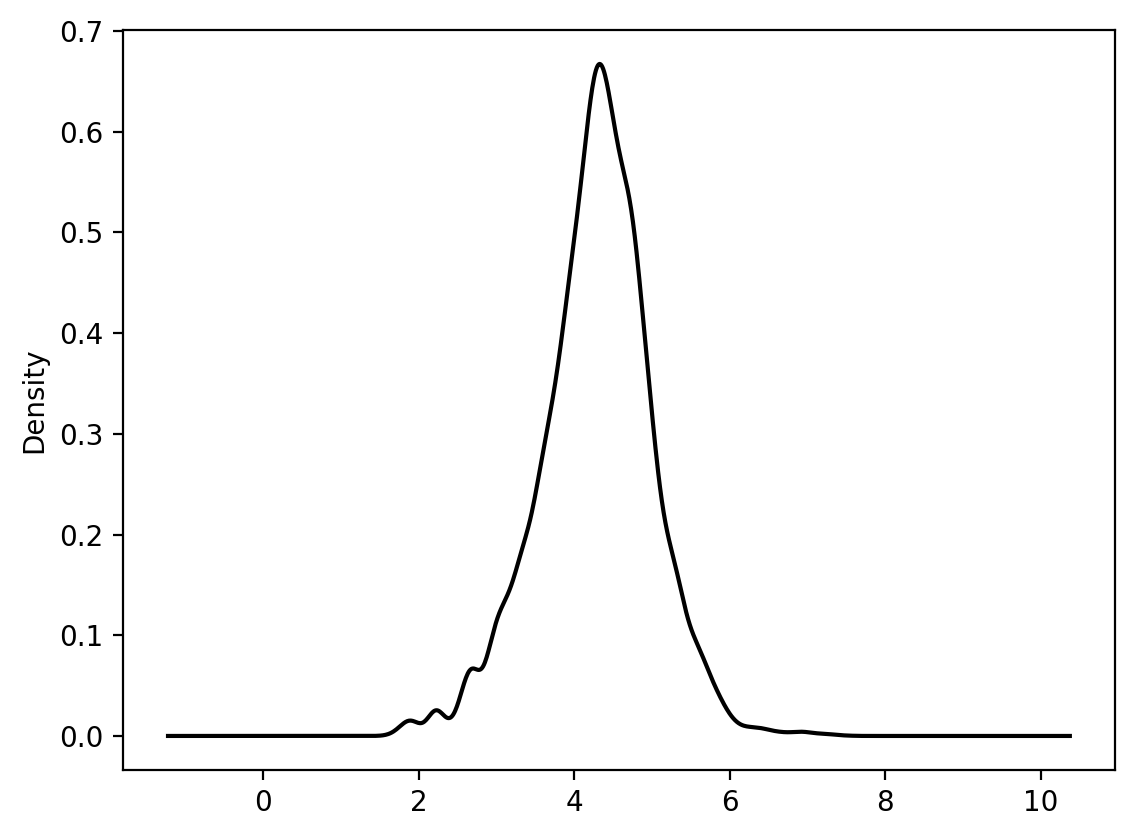

In [ ]:
# Distribution of distance traveled in a 6 hour time interval for all hurricanes
dist = np.log(dist)
ser = pd.Series(dist)
ser.plot(kind='kde', cmap='gray')
# plt.savefig('distance_dist')

In [ ]:
scipy.stats.anderson(dist, dist='norm')

AndersonResult(statistic=39.930066824075766, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=4.2816685710214335, scale=0.7173992111469155)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

In [ ]:
import sklearn

dist_norm = normalized = (dist-min(dist))/(max(dist)-min(dist))
scipy.stats.anderson(dist_norm, dist='norm')

AndersonResult(statistic=39.930066824075766, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.4489989840449202, scale=0.1237102329190213)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

<Axes: ylabel='Density'>

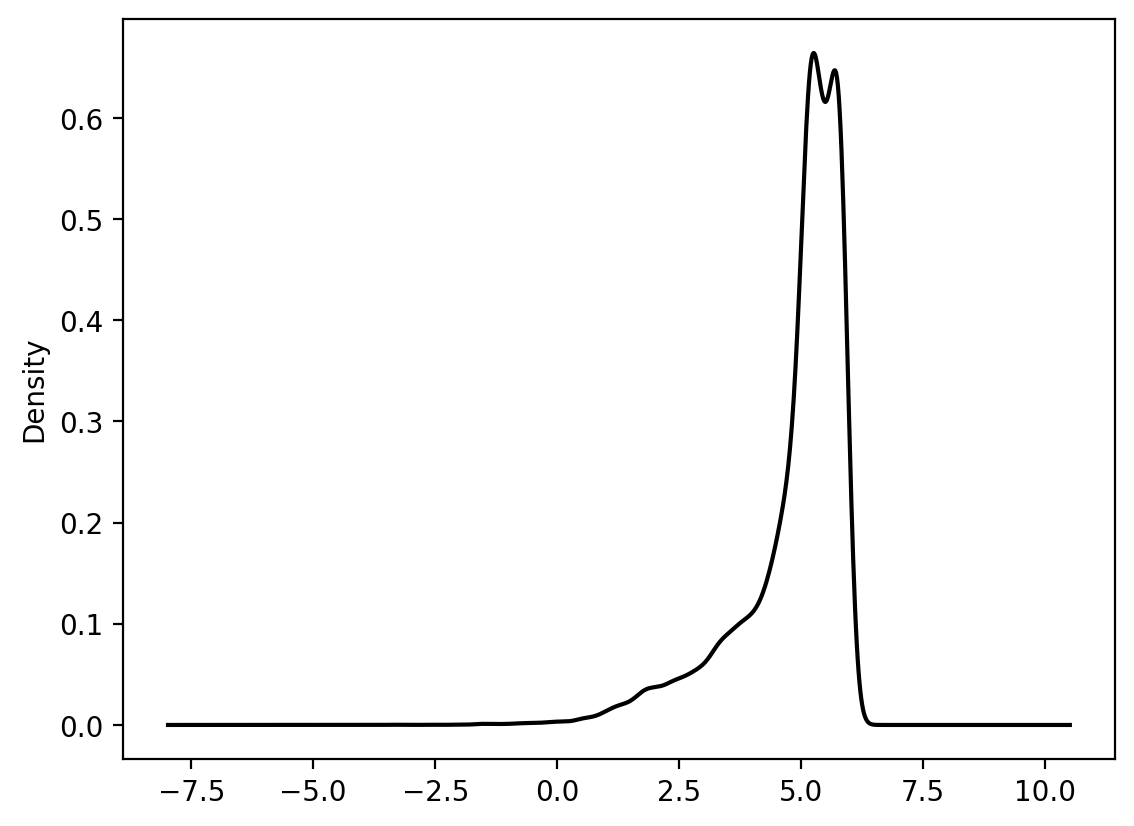

In [ ]:
# Distribution of angle traveled in a 6 hour time interval for all hurricanes
direc = data[data['direction'] > 0]
direc = np.log(direc['direction'])
ser = pd.Series(direc)
ser.plot(kind='kde', cmap='gray')
# plt.savefig('distance_dist')

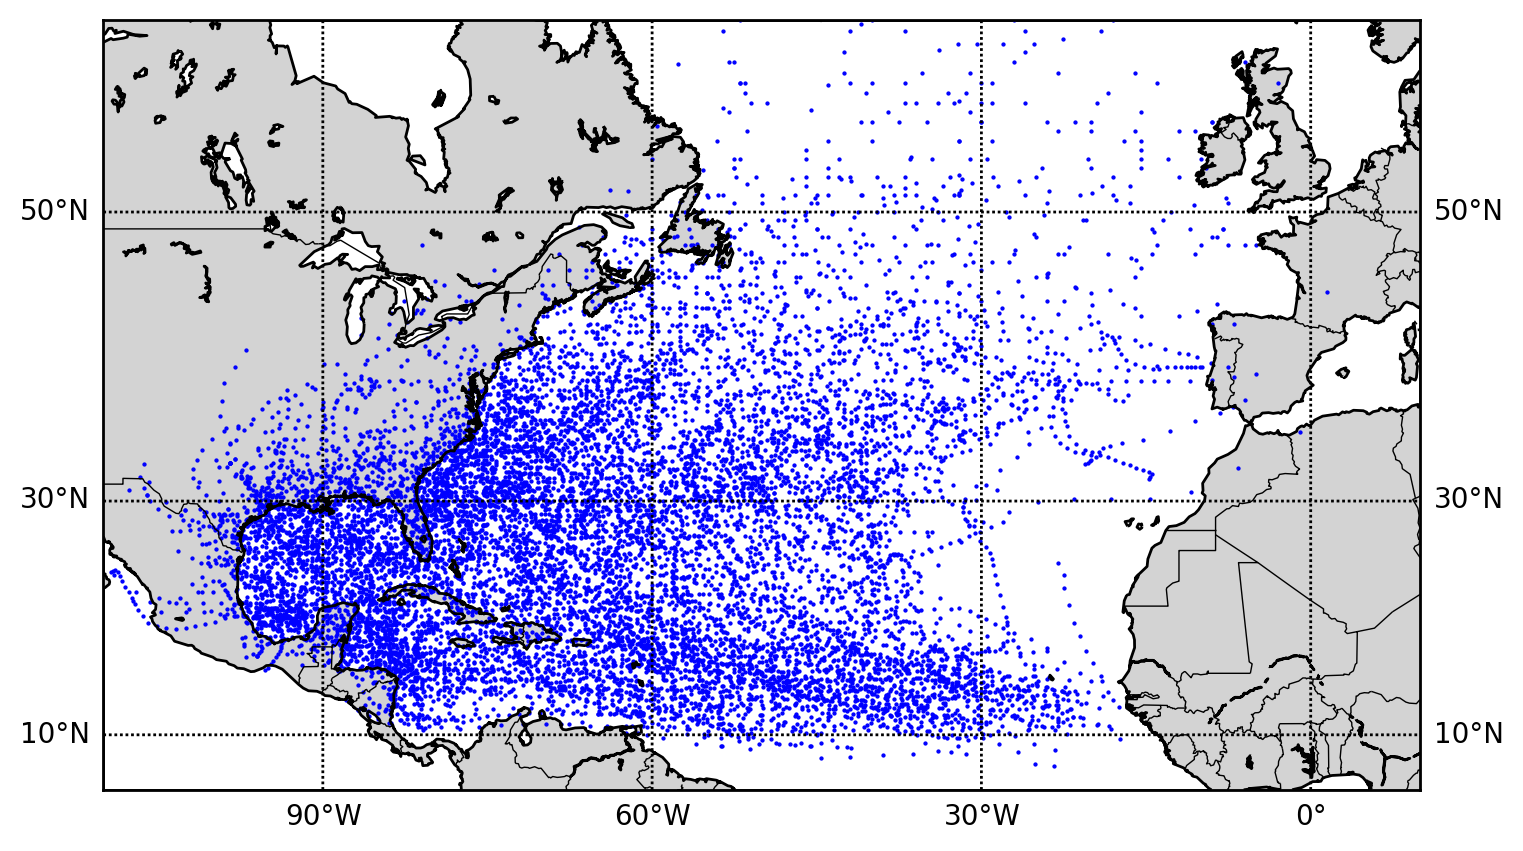

In [ ]:
# Graph all points
plt.figure(figsize=(10,5))
m = Basemap(llcrnrlon=-110.,llcrnrlat=5.,urcrnrlon=10.,urcrnrlat=60.,
            rsphere=(6378137.00,6356752.3142),
            resolution='l',
            projection='merc',
            lat_0=40.,lon_0=-20.,lat_ts=20.)
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='#D3D3D3')
m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])

lat = data['Lat'].values
long = data['Long'].values
xpt, ypt = m(long, lat)
m.scatter(xpt, ypt, .3, color='blue')

# plt.savefig('scatter_hurricanes')
plt.show()

In [ ]:
print(len(xpt))

13131


In [ ]:
data.describe()

,Month,Day,Hour,Lat,Long,WindSpeed,Pressure,distance,direction
count,13131.000000,13131.000000,13131.000000,13131.000000,13131.000000,13131.000000,13131.000000,13131.000000,13131.000000
mean,8.724621,15.828269,9.186810,26.928840,-64.398149,50.883939,993.863834,89.040334,171.462696
std,1.375840,8.906905,6.729553,9.812459,20.182565,25.903755,18.023786,85.472364,112.500395
min,1.000000,1.000000,0.000000,7.200000,-109.300000,10.000000,882.000000,0.000000,0.000000
25%,8.000000,8.000000,6.000000,18.900000,-80.700000,30.000000,987.000000,43.506747,70.936725
50%,9.000000,16.000000,12.000000,26.700000,-65.800000,45.000000,1000.000000,72.753758,177.126694
75%,10.000000,24.000000,18.000000,33.300000,-49.500000,65.000000,1007.000000,111.150007,264.471076
max,12.000000,31.000000,23.000000,66.000000,13.500000,165.000000,1024.000000,1766.824886,359.938162


In [ ]:
data.to_csv('checkpoint-dataframe-2.0.csv') # Save the dataframe to csv for checkpoint

### Build the Model

In [ ]:
data = pd.read_csv('checkpoint-dataframe-2.0.csv', index_col=0)

In [ ]:
data.head() # Check loaded data

,Month,Day,Hour,Lat,Long,WindSpeed,Pressure,unique-key,distance,direction
116,8,13,18,22.5,-93.5,30.0,1008,BERYL-2000-5,0.000000,0.000000
117,8,14,0,22.7,-93.8,30.0,1008,BERYL-2000-5,23.604117,140.567975
118,8,14,6,23.1,-94.6,35.0,1007,BERYL-2000-5,57.935076,161.351184
119,8,14,12,23.5,-95.4,40.0,1009,BERYL-2000-5,57.802056,174.302218
120,8,14,18,23.9,-96.3,45.0,1009,BERYL-2000-5,63.292296,337.250833


In [ ]:
names = data['unique-key'].unique()
data.drop(['Month', 'Day', 'Hour'], axis = 1, inplace = True)
data.head()

,Lat,Long,WindSpeed,Pressure,unique-key,distance,direction
116,22.5,-93.5,30.0,1008,BERYL-2000-5,0.000000,0.000000
117,22.7,-93.8,30.0,1008,BERYL-2000-5,23.604117,140.567975
118,23.1,-94.6,35.0,1007,BERYL-2000-5,57.935076,161.351184
119,23.5,-95.4,40.0,1009,BERYL-2000-5,57.802056,174.302218
120,23.9,-96.3,45.0,1009,BERYL-2000-5,63.292296,337.250833


In [ ]:
len(names)

539

In [ ]:
np.array(data)

array([[22.5, -93.5, 30.0, ..., 'BERYL-2000-5', 0.0, 0.0],
       [22.7, -93.8, 30.0, ..., 'BERYL-2000-5', 23.60411650844807,
        140.56797538055898],
       [23.1, -94.6, 35.0, ..., 'BERYL-2000-5', 57.93507557987407,
        161.35118414564937],
       ...,
       [30.2, -85.7, 70.0, ..., 'NOTNAMED-1929-2', 479.9202138698258,
        32.902723473217954],
       [30.4, -85.4, 60.0, ..., 'NOTNAMED-1929-2', 22.61060368758486,
        19.576091043963004],
       [31.0, -84.2, 55.0, ..., 'NOTNAMED-1929-2', 82.46837457733908,
        58.54528785490512]], dtype=object)

In [ ]:
np.unique(data['unique-key'])

array(['ABBY-1968-1', 'AGNES-1972-2', 'ALBERTO-1982-1', 'ALBERTO-1988-1',
       'ALBERTO-1994-1', 'ALBERTO-2006-1', 'ALBERTO-2012-1',
       'ALEX-1998-1', 'ALEX-2004-1', 'ALEX-2010-1', 'ALICE-1973-4',
       'ALICIA-1983-3', 'ALLEN-1980-4', 'ALLISON-1989-2',
       'ALLISON-1995-1', 'ALLISON-2001-1', 'ALMA-1962-1', 'ALMA-1966-1',
       'ALMA-1970-1', 'ALPHA-1972-1', 'ALPHA-2005-26', 'AMY-1975-2',
       'ANA-1979-2', 'ANA-1985-1', 'ANA-1991-1', 'ANA-1997-2',
       'ANA-2003-1', 'ANA-2009-2', 'ANDREA-2007-1', 'ANDREW-1986-1',
       'ANDREW-1992-4', 'ANITA-1977-5', 'ANNA-1961-1', 'ANNA-1969-6',
       'ANNA-1976-6', 'ARLENE-1963-1', 'ARLENE-1967-11', 'ARLENE-1981-3',
       'ARLENE-1993-2', 'ARLENE-1999-1', 'ARLENE-2005-1', 'ARLENE-2011-1',
       'ARTHUR-1984-6', 'ARTHUR-1990-2', 'ARTHUR-1996-1', 'ARTHUR-2002-1',
       'ARTHUR-2008-1', 'BABE-1977-6', 'BARRY-1983-4', 'BARRY-1989-3',
       'BARRY-1995-2', 'BARRY-2001-3', 'BARRY-2007-2', 'BECKY-1970-2',
       'BELLE-1976-7', 'BERTH

In [ ]:
data.head()

,Lat,Long,WindSpeed,Pressure,unique-key,distance,direction
116,22.5,-93.5,30.0,1008,BERYL-2000-5,0.000000,0.000000
117,22.7,-93.8,30.0,1008,BERYL-2000-5,23.604117,140.567975
118,23.1,-94.6,35.0,1007,BERYL-2000-5,57.935076,161.351184
119,23.5,-95.4,40.0,1009,BERYL-2000-5,57.802056,174.302218
120,23.9,-96.3,45.0,1009,BERYL-2000-5,63.292296,337.250833


In [ ]:
# chuẩn hóa các giá trị để giúp mô hình dự đoán dễ hơn
scalers = {}

for name in names:
    scalers[name] = MinMaxScaler(feature_range=(0, 1))

    hurricane = data[data['unique-key'] == name]
    hurricane.drop('unique-key', axis = 1, inplace= True)

    hurricane = pd.DataFrame(scalers[name].fit_transform(hurricane), columns=['Lat',
                                                                              'Long',
                                                                              'WindSpeed',
                                                                              'Pressure',
                                                                              'distance',
                                                                              'direction' ])
    data.loc[data['unique-key'] == name, ['Lat', 'Long', 'WindSpeed', 'Pressure', 'distance', 'direction']] = hurricane.values

<ipython-input-48-71171f5f0b4d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hurricane.drop('unique-key', axis = 1, inplace= True)
<ipython-input-48-71171f5f0b4d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hurricane.drop('unique-key', axis = 1, inplace= True)
<ipython-input-48-71171f5f0b4d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hurricane.drop('unique-key', axis = 1, inplace= True)
<ipython-input-48-71171f5f0b4d>:8:

In [ ]:
data.head()

,Lat,Long,WindSpeed,Pressure,unique-key,distance,direction
116,0.000000,1.000000,0.25,0.2,BERYL-2000-5,0.000000,0.000000
117,0.074074,0.952381,0.25,0.2,BERYL-2000-5,0.302926,0.412575
118,0.222222,0.825397,0.50,0.0,BERYL-2000-5,0.743516,0.473574
119,0.370370,0.698413,0.75,0.4,BERYL-2000-5,0.741808,0.511586
120,0.518519,0.555556,1.00,0.4,BERYL-2000-5,0.812268,0.989849


In [ ]:
data_pad = []
for key in np.unique(data['unique-key']):
    data_pad += [data[ data.loc[:, 'unique-key'] == key].loc[:, ['Lat','Long', 'WindSpeed', 'Pressure', 'distance', 'direction']]]

In [ ]:
# np.unique sắp xếp giá trị A->Z nên 2 bảng trên và dưới có giá trị được hiển thị khác nhau
data_pad[0]

,Lat,Long,WindSpeed,Pressure,distance,direction,unique-key,Month,Day,Hour
21217,18.8,-85.8,30.0,1005,0.000000,0.000000,ABBY-1968-1,6,2,0
21220,21.4,-84.8,40.0,1002,190.999054,230.915394,ABBY-1968-1,6,2,18
21221,22.3,-84.2,45.0,997,73.125660,248.497817,ABBY-1968-1,6,3,0
21222,23.3,-83.9,60.0,999,71.686942,348.773839,ABBY-1968-1,6,3,6
21223,24.5,-83.6,65.0,999,85.050130,14.434896,ABBY-1968-1,6,3,12
21225,25.1,-83.3,65.0,994,45.526444,17.180714,ABBY-1968-1,6,4,0
21226,25.8,-82.9,60.0,993,54.424009,18.917150,ABBY-1968-1,6,4,6
21227,26.9,-82.1,55.0,992,90.717511,350.544696,ABBY-1968-1,6,4,12
21230,28.1,-80.9,50.0,994,110.827466,292.193468,ABBY-1968-1,6,5,6
21232,27.8,-80.2,50.0,965,47.486532,321.421596,ABBY-1968-1,6,5,18


In [ ]:
len_vals = []
for x in range(len(data_pad)):
    len_vals += [len(data_pad[x])]
print(max(len_vals))
print(min(len_vals))

59
7


In [ ]:
from tensorflow.keras.utils import pad_sequences
padded_data = pad_sequences(data_pad, maxlen=60, dtype='float', padding='post', truncating='pre', value=0.0)

In [ ]:
padded_data[0]

array([[0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        ],
       [0.22033898, 0.17241379, 0.28571429, 0.925     , 0.9498148 ,
        0.6587331 ],
       [0.29661017, 0.27586207, 0.42857143, 0.8       , 0.36364491,
        0.70889053],
       [0.38135593, 0.32758621, 0.85714286, 0.85      , 0.35649035,
        0.99494827],
       [0.48305085, 0.37931034, 1.        , 0.85      , 0.42294383,
        0.04117848],
       [0.53389831, 0.43103448, 1.        , 0.725     , 0.22639741,
        0.04901148],
       [0.59322034, 0.5       , 0.85714286, 0.7       , 0.2706439 ,
        0.05396502],
       [0.68644068, 0.63793103, 0.71428571, 0.675     , 0.45112703,
        1.        ],
       [0.78813559, 0.84482759, 0.57142857, 0.725     , 0.55113136,
        0.83354126],
       [0.76271186, 0.96551724, 0.57142857, 0.        , 0.23614468,
        0.91692044],
       [0.77966102, 1.        , 0.57142857, 0.8       , 0.09170885,
        0.993035  ],
       [1.        , 0

In [ ]:
print(len(padded_data[0]))
print(len(padded_data))

60
539


In [ ]:
padded_data.shape

(539, 60, 6)

In [ ]:
temp_flat = padded_data.reshape(60*539, 6)
print(temp_flat[0:100])
print(temp_flat.shape)

[[0.         0.         0.         1.         0.         0.        ]
 [0.22033898 0.17241379 0.28571429 0.925      0.9498148  0.6587331 ]
 [0.29661017 0.27586207 0.42857143 0.8        0.36364491 0.70889053]
 [0.38135593 0.32758621 0.85714286 0.85       0.35649035 0.99494827]
 [0.48305085 0.37931034 1.         0.85       0.42294383 0.04117848]
 [0.53389831 0.43103448 1.         0.725      0.22639741 0.04901148]
 [0.59322034 0.5        0.85714286 0.7        0.2706439  0.05396502]
 [0.68644068 0.63793103 0.71428571 0.675      0.45112703 1.        ]
 [0.78813559 0.84482759 0.57142857 0.725      0.55113136 0.83354126]
 [0.76271186 0.96551724 0.57142857 0.         0.23614468 0.91692044]
 [0.77966102 1.         0.57142857 0.8        0.09170885 0.993035  ]
 [1.         0.74137931 0.57142857 0.85       1.         0.63702387]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.        

In [ ]:
def load_data(stock, seq_len, amount_of_features):
    sequence_length = seq_len + 1 # Because index starts at 0
    result = []

    for index in range(len(stock) - sequence_length):
        seq = stock[index: index + sequence_length]
        result.append(seq)

    result = np.array(result)
    row = len(result) * 0.85 # Amount of data to train on
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:, :2]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:, :2]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))

    return [x_train, y_train, x_test, y_test]

### Transformer

In [ ]:
# def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
#     # Normalization and Attention
#     x = layers.LayerNormalization(epsilon=1e-6)(inputs)
#     x = layers.MultiHeadAttention(
#         key_dim=head_size, num_heads=num_heads, dropout=dropout
#     )(x, x)
#     x = layers.Dropout(dropout)(x)
#     res = x + inputs

#     # Feed Forward Part
#     x = layers.LayerNormalization(epsilon=1e-6)(res)
#     x = layers.Dense(ff_dim, activation="relu")(x)
#     x = layers.Dropout(dropout)(x)
#     x = layers.Dense(inputs.shape[-1])(x)
#     x = layers.Dropout(dropout)(x)
#     return x + res

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalize
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    res = layers.LayerNormalization(epsilon=1e-6)(x + inputs)

    # Feed Forward Part
    x = layers.Dense(ff_dim)(res)
    x = activations.gelu(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1])(x)
    x = layers.Dropout(dropout)(x)
    return layers.LayerNormalization(epsilon=1e-6)(x + res)

In [ ]:
def build_model(
    input_shape,
    output_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim)(x)
        x = activations.gelu(x)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(output_shape, activation='linear')(x)

    return keras.Model(inputs, outputs)

### Train the Model

In [ ]:
seq_len = 12 # Another hyperparameter- length of hurricane?
feature_count = 6
X_train, y_train, X_test, y_test = load_data(temp_flat[::-1], seq_len, feature_count)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (27477, 12, 6)
y_train (27477, 2)
X_test (4850, 12, 6)
y_test (4850, 2)


In [ ]:
model = build_model(
    input_shape=X_train.shape[1:],
    output_shape=2,
    head_size=256,
    num_heads=6,
    ff_dim=120,
    num_transformer_blocks=3,
    mlp_units=[6],
    mlp_dropout=0.35,
    dropout=0.3,
)

model.compile(
    loss="mse",
    optimizer='adam',
    metrics=["mae"],
)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 12, 6)]      0           []                               
                                                                                                  
 multi_head_attention_9 (MultiH  (None, 12, 6)       41478       ['input_4[0][0]',                
 eadAttention)                                                    'input_4[0][0]']                
                                                                                                  
 dropout_29 (Dropout)           (None, 12, 6)        0           ['multi_head_attention_9[0][0]'] 
                                                                                                  
 tf.__operators__.add_18 (TFOpL  (None, 12, 6)       0           ['dropout_29[0][0]',       

In [ ]:
callbacks = [keras.callbacks.EarlyStopping(monitor="val_mae", patience=10, restore_best_weights=True)]

model.fit(X_train, y_train, batch_size=1024, epochs=150, validation_split=0.1, verbose=1)

Epoch 1/150
25/25 [==============================] - 15s 175ms/step - loss: 0.1089 - mae: 0.1783 - val_loss: 0.0896 - val_mae: 0.1729
Epoch 2/150
25/25 [==============================] - 4s 145ms/step - loss: 0.0932 - mae: 0.1889 - val_loss: 0.0749 - val_mae: 0.1814
Epoch 3/150
25/25 [==============================] - 4s 151ms/step - loss: 0.0783 - mae: 0.1923 - val_loss: 0.0639 - val_mae: 0.1799
Epoch 4/150
25/25 [==============================] - 4s 153ms/step - loss: 0.0708 - mae: 0.1812 - val_loss: 0.0576 - val_mae: 0.1587
Epoch 5/150
25/25 [==============================] - 4s 152ms/step - loss: 0.0663 - mae: 0.1655 - val_loss: 0.0530 - val_mae: 0.1489
Epoch 6/150
25/25 [==============================] - 4s 145ms/step - loss: 0.0631 - mae: 0.1611 - val_loss: 0.0497 - val_mae: 0.1363
Epoch 7/150
25/25 [==============================] - 4s 151ms/step - loss: 0.0608 - mae: 0.1538 - val_loss: 0.0471 - val_mae: 0.1315
Epoch 8/150
25/25 [==============================] - 4s 147ms/step -

In [ ]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Loss: %.4f MSE (%.4f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: %.4f MSE (%.4f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Loss: 0.0236 MSE (0.1537 RMSE)
Test Loss: 0.0290 MSE (0.1702 RMSE)


In [ ]:
print('Train Metrics: %.4f MAE' % (trainScore[1]))
print('Test Metric: %.4f MAE' % (testScore[1]))

Train Metrics: 0.0893 MAE
Test Metric: 0.0967 MAE


In [ ]:
#SAVING MODEL

# Serialize model to JSON
model_json = model.to_json()
with open("model_transformer_latlong.json", "w") as json_file:
    json_file.write(model_json)

# Serialize weights to HDF5
model.save_weights("model_transformer_latlong.h5")
print("Saved Model to Disk")

Saved Model to Disk


### Predicting Hurricane Trajectory

In [ ]:
# Load json and create model
json_file = open('model_transformer_latlong.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# Load weights into new model
loaded_model.load_weights("model_transformer_latlong.h5")
print("Loaded Model from Disk")
model = loaded_model

# Evaluate loaded model on test data
#loaded_model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])
#score = loaded_model.evaluate(X, Y, verbose=0)
#print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

In [ ]:
pred = model.predict(X_test)

152/152 [==============================] - 2s 8ms/step


In [ ]:
pred.shape

(4850, 2)

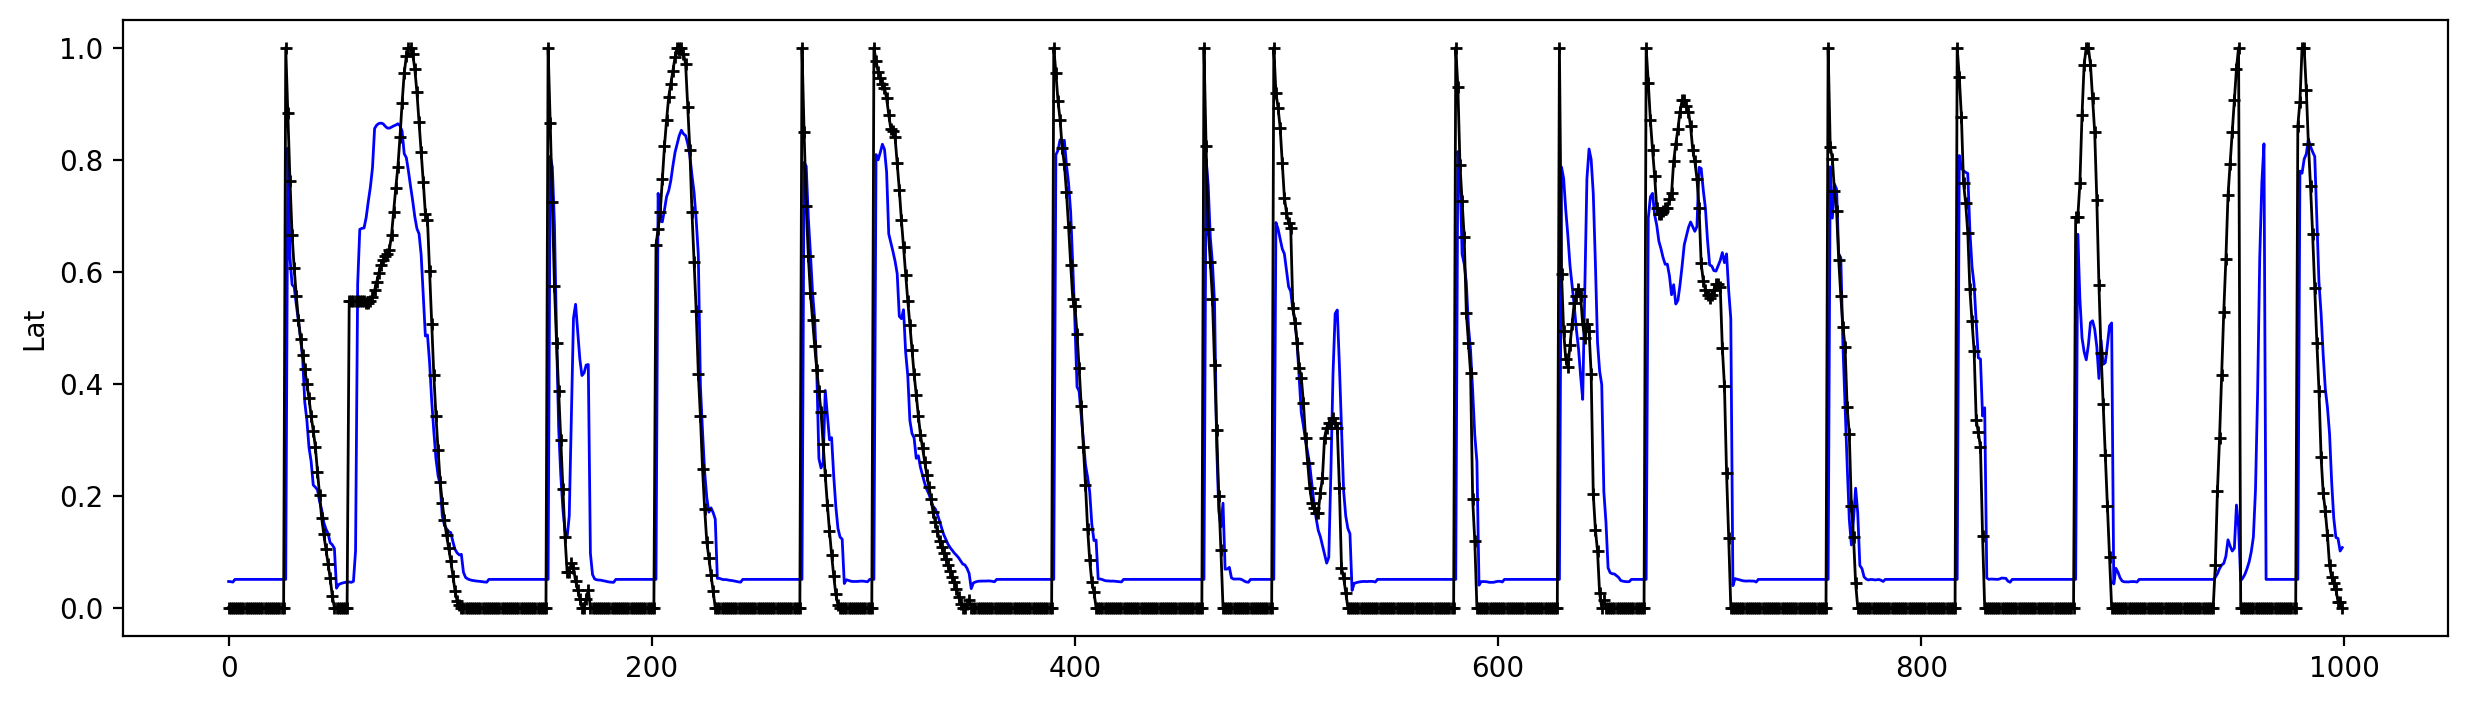

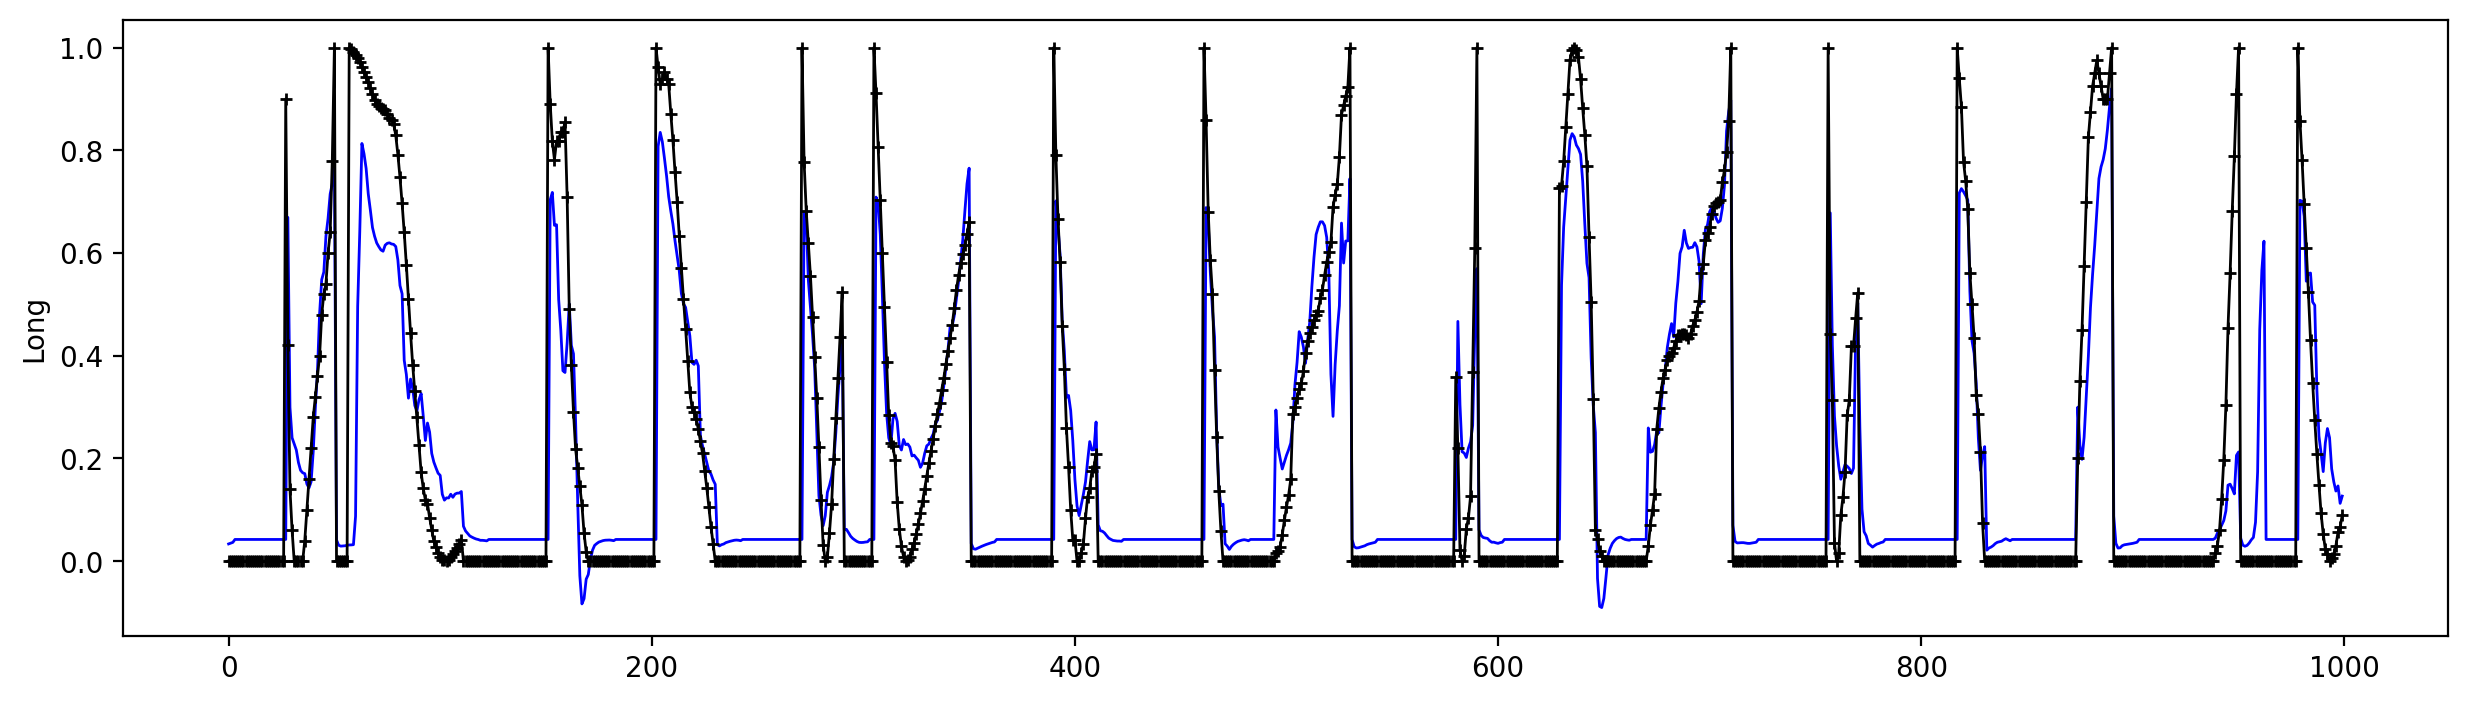

In [ ]:
features = ['Lat','Long']
for i in range(len(features)):
  plt.figure(figsize=(15, 4), dpi=100)

  plt.plot(pred[:1000, i],
          linewidth=1,
          color='blue',
          label=f'Predicted {features[i]} Locations')
  plt.plot(y_test[:1000, i],
          linewidth=1,
          color='black',
          marker='+',
          markersize=4,
          label=f'Real {features[i]} Locations')
  # # plt.savefig('denormalized_predictions')
  # plt.xlabel('Data Tuple')
  plt.ylabel(features[i])

  # plt.legend(loc='upper left')
  # # plt.savefig('grid_accuracy.png')


In [ ]:
len(pred)

In [ ]:
plt.figure(figsize=(15, 1), dpi=100)
plt.plot(pred,
         linewidth=1,
         color='blue',
         label='Predicted Locations')
plt.plot(y_test,
         linewidth=1,
         color='black',
         marker='+',
         markersize=4,
         label='Real Grid Locations')
# plt.savefig('denormalized_predictions')
plt.xlabel('Data Tuple')
plt.ylabel('Grid Locations')

plt.legend(loc='upper left')
# plt.savefig('grid_accuracy.png')
plt.show()

In [ ]:
plt.figure(figsize=(15, 4), dpi=100)
plt.plot(pred[:150],
         linewidth=1,
         color='blue',
         label='Predicted Grid Locations')
plt.plot(y_test[:150],
         linewidth=1,
         color='black',
         marker='+',
         markersize=4,
         label='Real Grid Locations')
# plt.savefig('denormalized_predictions')
plt.xlabel('Data Tuple')
plt.ylabel('Grid Locations')

plt.legend(loc='upper left')
# plt.savefig('grid_accuracy.png')
plt.show()

In [ ]:
pred[0:60].flatten()

In [ ]:
flat_pred = pred.flatten()

In [ ]:
y_test[0:80]

In [ ]:
hurr_real = []
hurr_pred = []
temp_real = []
temp_pred = []
for x in range(len(y_test)):
#     print(y_test[x])
    if not y_test[x] == 0:
        temp_real += [y_test[x]]
#         print(len(temp_real))
        temp_pred += [flat_pred[x]]
#         print(len(temp_pred))
    else:
        hurr_real += [temp_real]
#             print(hurr_real)
        hurr_pred += [temp_pred]
#             print(hurr_pred)
#             print(' ')
#             plt.plot(hurr_real, hurr_pred)
        temp_real = []
        temp_pred = []


In [ ]:
print(len(hurr_real))
print(len(hurr_pred))

lol_real = [x for x in hurr_real if bool(x)]
print(len(lol_real))
lol_pred = [x for x in hurr_pred if bool(x)]
print(len(lol_pred))

In [ ]:
len(data[data['unique-key'] == 'NOTNAMED-1929-2'])

In [ ]:
data.tail(10)

In [ ]:
for x in range(len(lol_real)):
    if len(lol_real[x]) > 12:
        plt.plot(lol_pred[x][1:], linewidth=1, color='blue', label='Predicted Grid Locations')
#         plt.plot(lol_pred_temp[x][1:14], label='Training Grid Locations')
#         plt.plot(list(range(12, len(lol_pred_temp[x]))), lol_pred_temp[x][12:], label='Predicted Grid Locations')
        plt.plot(lol_real[x][1:], linewidth=1, color='black', marker='+', markersize=4, label='Real Grid Locations')
        plt.title('TEST')
        plt.xlabel('Data Tuple')
        plt.ylabel('Grid Locations')
        plt.legend()
        plt.show()

In [ ]:
for x in range(len(lol_real)):
    if len(lol_real[x]) > 12:
#         plt.plot(lol_pred[x][1:], linewidth=1, color='blue', label='Predicted Grid Locations')
        plt.plot(lol_pred[x][1:14], label='Training Grid Locations')
        plt.plot(list(range(12, len(lol_pred[x]))), lol_pred[x][12:], label='Predicted Grid Locations')
        plt.plot(list(range(12, len(lol_pred[x]))), lol_real[x][12:], linewidth=1, color='black', marker='+', markersize=4, label='Real Grid Locations')
        plt.title('TEST')
        plt.xlabel('Data Tuple')
        plt.ylabel('Grid Locations')
        plt.legend()
        plt.show()

In [ ]:
model.summary()
model.get_config()